# Convergence




Sometimes a system simulation might not converge on the first try. This section presents strategies to get to convergence. First, let's setup a system that will not converge. In this case, a nitrogen liquefaction loop including a heat exchanger, an expansion valve and a flash drum.

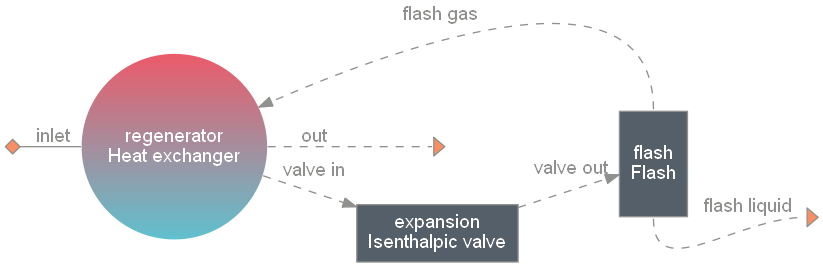

In [24]:
import biosteam as bst

# Setup thermodynamic backend
N2 = bst.Chemical('N2')
bst.settings.set_thermo([N2])
N2.Cn.g.method = N2.Cn.l.method = "COOLPROP" # Use coolprop
N2.reset_free_energies()
bst.settings.mixture.include_excess_energies = True

inlet = bst.Stream("inlet", N2=2.75, units="kg/s", T=6.85+273.15, P=200e5, phase="g")

# recycle HX
regenerator = bst.units.HXprocess("regenerator", ins=(inlet, "flash_gas"), outs=("throttle_in", 'out'), dT=9.55)
throttle_in = regenerator.outs[0]

# throttling
valve = bst.units.IsenthalpicValve("expansion", ins=throttle_in, outs="valve_out", P=1e5, vle=True)
valve_out = valve.outs[0]

# flash drum
flash = bst.units.Flash("flash", ins=valve_out, outs=("flash_gas", "flash_liquid"), Q=0, P=1e5)
gas_out = flash.outs[0]
liquid_out = flash.outs[1]

# connect flash gas to regenerator
regenerator.ins[1] = gas_out

# run simulation
sys = bst.main_flowsheet.create_system('flowsheet_sys')
sys.simulate()
regenerator.outs[0].show()

We want to use the COOLPROP method to calculate liquid N2 enthalpies. This is more accurate than the default DADGOSTAR_SHAW method, but also less stable. It will cause the solver to fail.

In [25]:
settings.chemicals["N2"].Cn.l.method = "COOLPROP"
settings.chemicals["N2"].reset_free_energies()
sys.simulate()
# Note: Thanks to some fixes in Biosteam, there is no error here anymore. Coolprop converges just fine. 
# For the sake of demonstration, let's still pretend a convergence error is raised.

## Two-step convergence

One way to circumvent the error is to approach the correct solution by using a less accurate but stable method, then refine the simulation result with the more accurate method:

In [26]:
settings.chemicals["N2"].Cn.l.method = "DADGOSTAR_SHAW" # switching to stable method for convergence
settings.chemicals["N2"].reset_free_energies()
sys.simulate() # success!
regenerator.show()

HXprocess: regenerator
ins...
[0] inlet
    phase: 'g', T: 280 K, P: 2e+07 Pa
    flow (kmol/hr): N2  1
[1] flash_gas  from  Flash-flash
    phase: 'g', T: 77.236 K, P: 100000 Pa
    flow (kmol/hr): N2  0.929
outs...
[0] valve_in  to  IsenthalpicValve-expansion
    phases: ('g', 'l'), T: 168.77 K, P: 2e+07 Pa
    flow (kmol/hr): (g) N2  0.982
                    (l) N2  0.0178
[1] out
    phase: 'g', T: 270 K, P: 100000 Pa
    flow (kmol/hr): N2  0.914


In [27]:
settings.chemicals["N2"].Cn.l.method = "COOLPROP" # switching back to accurate method for precision
settings.chemicals["N2"].reset_free_energies()
sys.simulate(skip_setup=True) # the skip_setup flag is necessary to make the solver start from the previous result
regenerator.show()

HXprocess: regenerator
ins...
[0] inlet
    phase: 'g', T: 280 K, P: 2e+07 Pa
    flow (kmol/hr): N2  1
[1] flash_gas  from  Flash-flash
    phase: 'g', T: 77.236 K, P: 100000 Pa
    flow (kmol/hr): N2  0.913
outs...
[0] valve_in  to  IsenthalpicValve-expansion
    phase: 'l', T: 126.2 K, P: 2e+07 Pa
    flow (kmol/hr): N2  1
[1] out
    phase: 'g', T: 270 K, P: 100000 Pa
    flow (kmol/hr): N2  0.929


This approach can also be used to speed up our simulations. Instead of doing hundreds of iterations with a slow-but-accurate method, we can get close to the result with a fast-but-inaccurate method and then refine the result after.

## Adjusting convergence criteria

Another way to enforce convergence is by redefining what convergence means. Sometimes the default accuracies in Biosteam might be too strict. Here are some ways to adjust them.

There is an option for systems to run mass and energy balances a given number of times called N_run (but this disregards recycle loops). You can use:

In [28]:
sys.recycle = None
sys.N_runs = 100

You might also want to play around with the solver algorithms and their tolerances (which can be high for some things; absolute molar tolerance is 1 kmol/hr by default):

In [29]:
# we can also change the method and number of iterations (optionally)
# method can be any one of 'aitken', 'wegstein', 'fixedpoint', 'anderson', 'diagbroyden', 
# 'excitingmixing', 'linearmixing', 'newtonkrylov', 'broyden1', 'broyden2', 'fsolve'
sys.set_tolerance(mol=0.0001, method='wegstein', maxiter=1000)

You can also reduce the tolerances for internal equilibrium and temperature solvers:

In [30]:
from thermosteam.equilibrium import VLE
from thermosteam.mixture import Mixture
VLE.maxiter = 1000
VLE.T_tol = 5e-16 # These are absolute tolerances
VLE.P_tol = 1e-16
VLE.H_hat_tol = 1e-16 # This is kJ/kg
VLE.S_hat_tol = 1e-16
VLE.V_tol = 1e-16
VLE.x_tol = 1e-16 # Molar fraction
VLE.y_tol = 1e-16
Mixture.T_tol = 1e-12
Mixture.maxiter = 500